In [ ]:
# install required packages
# !pip install tensorboard==2.2.1
# !pip install optuna
# !pip install clearml-agent
# !pip install clearml
# !pip install smart_open
# !pip install ipywidgets
# !pip install pycocotools
# !pip install opencv-python

In [ ]:
# general imports
import time
import numpy as np
import torchvision
import pandas as pd
from smart_open import smart_open
import boto3
import io
import torch
import PIL
from PIL import Image
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.utils
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import tempfile
import json
import pycocotools
import cv2


# torch.vision imports
# need to download torch vision files into working directory from https://github.com/pytorch/vision/tree/master/references/detection
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import coco_eval

#ClearML imports
from clearml.automation import UniformParameterRange, UniformIntegerParameterRange, DiscreteParameterRange
from clearml.automation import HyperParameterOptimizer
from clearml.automation.optuna import OptimizerOptuna
from clearml.automation.optimization import GridSearch
from clearml import Task

#matplotlib imports for inference/plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
#create base experiment on ClearML WebServer
#convert code to .py file, if you get warnings when instantiating task
train_task = Task.init(project_name='Faster_RCNN',
                       task_name='Base Model')

train_id = train_task.id

In [ ]:
#define hyperparameters with default values
configuration_dict = {'weight_decay': 0.0007, 'base_lr': 0.005, 'batch_size': 4, 'momentum': 0.95}
# enabling configuration override by clearml
configuration_dict = task_train.connect(configuration_dict)
print(configuration_dict)  # printing actual configuration (after override in remote mode)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def get_transform(train):
    transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, path='labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb',
                 path2='s3://labeling-test-ai-supported-enbeemoresearchdata-k8wchfbly0wb/bee-labeling-2k-batch-01/manifests/output/output.manifest', transform=None):
        self.path = path
        self.path2 = path2
        self.s3 = boto3.resource('s3')
        self.bucket = self.s3.Bucket(path)
        self.bucket2 = self.s3.Bucket(path2)
        self.files = self.create_file_list()
        self.boxes = self.create_boxes()
        self.image_ids = self.create_image_ids()
        self.transform = transform
            
    def create_boxes(self):
        boxes = []
        with smart_open(self.path2, 'rb') as s3_source:
            for line in s3_source:
                picture=json.loads(line.decode('utf8'))['bee-labeling-2k-batch-01']['annotations']
                pic_boxes=[]
                for box in picture:
                    x1=box['left']
                    y1=box['top']
                    x2=x1+box['width']
                    y2=y1+box['height']
                    pic_boxes.append([x1,y1,x2,y2])
                boxes.append(pic_boxes)
        boxes.pop(1281)
        return boxes
    
    def create_image_ids(self):
        image_list = []
        for file in self.files:
            string_list = [s for s in file.split('_') if s.isdigit()]
            image_id = str()
            for string in string_list:
                image_id+=string
            image_id = torch.tensor((int(image_id)), dtype=torch.int64)
            image_list.append(image_id)
        return image_list
    
    def create_file_list(self):
        files = [obj.key for obj in self.bucket.objects.all()][:2000]
        files.pop(1281)
        return files    

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        boxes = torch.tensor(self.boxes[idx])
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        iscrowd = torch.zeros(boxes.shape[0], dtype=torch.int64)
        area = (boxes[:,3]-boxes[:,1]) * (boxes[:,2]-boxes[:,0])
        image_id = self.image_ids[idx]
        targets={}
        targets['boxes']=boxes
        targets['labels']=labels
        targets['image_id']=image_id
        targets['area']=area
        targets['iscrowd']=iscrowd

        obj = self.bucket.Object(img_name)
        tmp = tempfile.NamedTemporaryFile()
        tmp_name = '{}.jpg'.format(tmp.name)

        with open(tmp_name, 'wb') as f:
            obj.download_fileobj(f)
            f.flush()
            f.close()
            image = Image.open(tmp_name)
        
        
        if self.transform is not None:
            image, targets = self.transform(image, targets)

        return image, targets
        

In [ ]:
#applies transformation to train set and splits train/val into 90/10
train_set = ImageDataset(transform=get_transform(train=True))
val_set = ImageDataset(transform=get_transform(train=False))
test_set = ImageDataset(transform=get_transform(train=False))

indices = torch.randperm(len(train_set)).tolist()
train_set = torch.utils.data.Subset(train_set, indices[:1800])
val_set = torch.utils.data.Subset(val_set, indices[1800:])


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


data_loader = torch.utils.data.DataLoader(
    train_set,
    configuration_dict.get('batch_size', 4),
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn)


data_loader_test = torch.utils.data.DataLoader(
    val_set,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn)


In [ ]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one by adjusting the number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=configuration_dict.get('base_lr', 0.005), momentum=configuration_dict.get('momentum', 0.95), weight_decay=configuration_dict.get('weight_decay', 0.0007))
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 6


tensorboard_writer = SummaryWriter('./tensorboard_logs')

In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    loss_list, iteration_list = train_one_epoch(model, optimizer, data_loader, device, epoch,
                    print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    summary = evaluate(model, data_loader_test, device=device)
    avg_precision = summary.coco_eval['bbox'].stats[1]

    tensorboard_writer.add_scalar('Average Precision .50/total', avg_precision, epoch)
    
    for loss, iteration in zip(loss_list, iteration_list):
        tensorboard_writer.add_scalar('loss',loss,iteration)
    

torch.save(model.state_dict(), 'model.pth')

In [ ]:
# initialize optimizer task
task_opt = Task.init(project_name='Faster_RCNN',
                     task_name='Hyperparameter Search',
                     task_type=Task.TaskTypes.optimizer)

In [ ]:

optimizer = HyperParameterOptimizer(
    base_task_id=train_id,  # This is the experiment we want to optimize
    # here we define the hyper-parameters to optimize
    hyper_parameters=[
        UniformParameterRange('General/weight_decay', min_value=0.0003,
                              max_value=0.0007, step_size=0.0002),
        UniformParameterRange('General/base_lr', min_value=0.003, max_value=0.007, step_size=0.002),
        UniformParameterRange('General/momentum', min_value=0.85, max_value=0.95, step_size=0.05),
        DiscreteParameterRange('General/batch_size', values=[2, 4, 8])
    ],
    # setting the objective metric we want to maximize/minimize
    objective_metric_title='Average Precision .50',
    objective_metric_series='total',
    objective_metric_sign='max',  # maximize or minimize the objective metric

    # setting optimizer - clearml supports GridSearch, RandomSearch, OptimizerBOHB and OptimizerOptuna
    optimizer_class=OptimizerOptuna,

    # Configuring optimization parameters
    execution_queue='default',  # queue to schedule the experiments for execution
    max_number_of_concurrent_tasks=2,  # number of concurrent experiments
    optimization_time_limit=6000.,  # set the time limit for the optimization process
    compute_time_limit=1200,  # set the compute time limit (sum of execution time on all machines)
    total_max_jobs=5,  # set the maximum number of experiments for the optimization.
                        # Converted to total number of iteration for OptimizerBOHB
    min_iteration_per_job=15000,  # minimum number of iterations per experiment, till early stopping
    max_iteration_per_job=150000,  # maximum number of iterations per experiment
)


In [ ]:
#run the following two commands in terminal first, to initialize and run the clearml agent daemon in background before starting the optimization
#!clearml-agent init
#set system_site_packages=true in the clearml.conf file before starting the daemon
#!clearml-agent daemon --queue default

optimizer.set_report_period(1)
optimizer.start()
optimizer.wait()
optimizer.stop()

In [ ]:
#load a trained model
loaded_model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 2
# get number of input features for the classifier
in_features = loaded_model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one by adjusting the number of classes
loaded_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

loaded_model.load_state_dict(torch.load('./best_model.pth'))
loaded_model.to(device)
loaded_model.eval()

In [ ]:
images, targets = next(iter(data_loader_test))
images = list(image.to(device) for image in images)

with torch.no_grad():
    outputs = loaded_model(images)

idx = 0

In [16]:
def plot_boundaries(boxes, color):
    for box in boxes:
        x1=box[0]
        y1=box[1]
        x2=box[2]
        y2=box[3]
        plt.gca().add_patch(Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor=color, facecolor='none'))

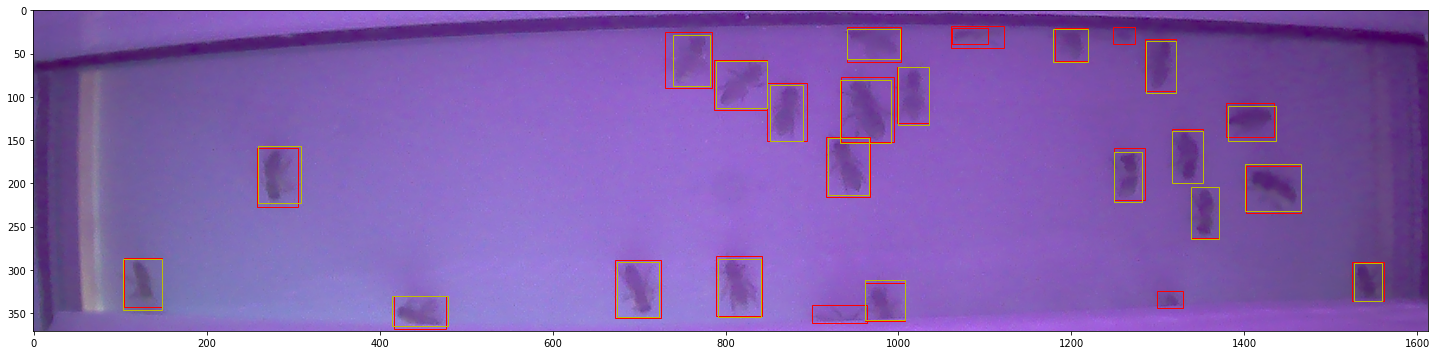

In [19]:
#apply inference on trained model

plt.rcParams["figure.figsize"] = (25,10)    
img = images[idx].permute(1,2,0).cpu().numpy()
#boxes = train_set[idx][1]['boxes']
boxes = outputs[idx]['boxes'].data.cpu().numpy()
targets = targets[idx]['boxes']
plt.imshow(img)

plot_boundaries(boxes, 'r')
plot_boundaries(targets, 'y')